In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [7]:
%matplotlib inline
plt.rcParams['figure.figsize'] = [15, 15]

In [3]:
filePath = '/Users/ranjeetsandhu/Documents/DataScience/Python/Projects_2021/shipFuelConsumption/predict-fuel-consumption/data/processed/final_features.csv'
df = pd.read_csv(filePath, index_col='Time', parse_dates=True)

In [4]:
df.head()

,fuelConsumption,HFO,shaftSpeed,speedWater,heading,rudderAngle,TWS,TWD,temp,meanDraft
Time,,,,,,,,,,
2017-07-06 13:15:00,0.0,0.0,84.878837,15.607449,167.741687,358.025169,6.675341,314.224434,20.283071,2.874424
2017-07-06 14:00:00,0.0,0.0,84.868300,15.776289,168.034239,357.967447,7.034934,308.615477,20.360865,2.877338
2017-07-06 15:00:00,0.0,0.0,84.874972,15.707046,152.496507,358.605730,7.778714,303.563221,20.534437,2.882920
2017-07-06 16:00:00,0.0,0.0,84.867446,15.723442,128.601049,358.864694,8.508143,300.737464,20.641539,2.886406
2017-07-06 17:00:00,0.0,0.0,84.864535,15.692471,107.945165,358.951153,8.541664,302.903406,20.662176,2.887449


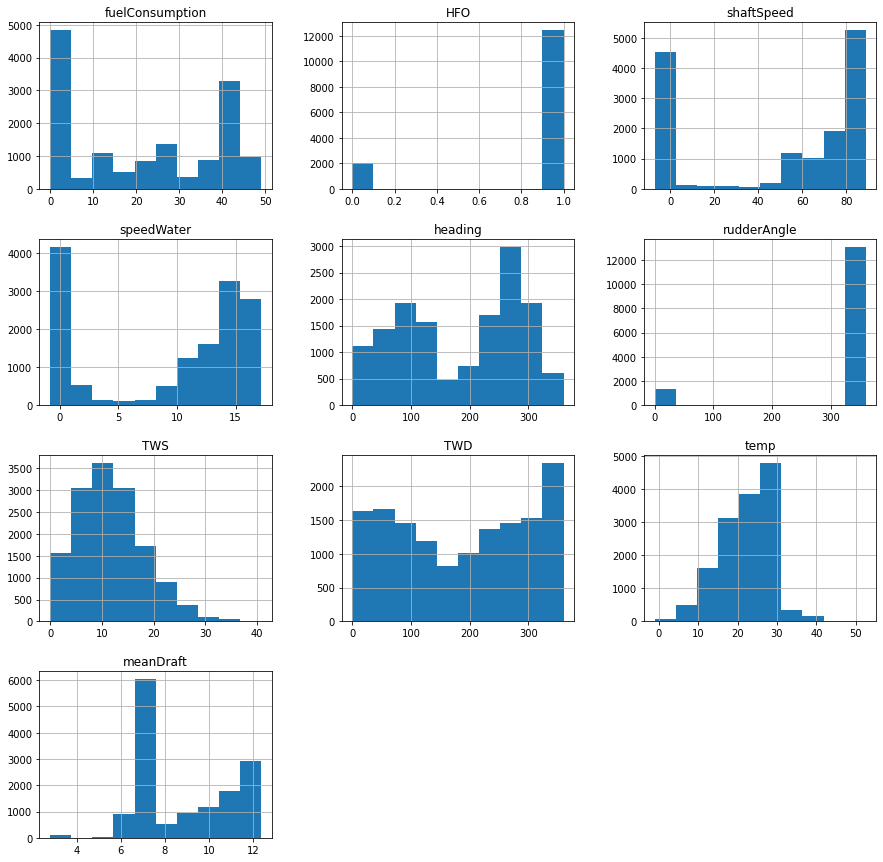

In [8]:
df.hist();

In [67]:
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

In [77]:
# Create feature and target arrays
features = df.drop('fuelConsumption', axis=1)
target = df[['fuelConsumption']]

In [83]:
# Test train split - train_test_split() method
X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.2, random_state=1)

# Copy of datasets
X_train_standard = X_train.copy()
X_test_standard = X_test.copy()

In [84]:
# numerical features
num_cols = ['shaftSpeed', 'speedWater', 'heading', 'TWS', 'TWD', 'temp', 'meanDraft']

scaler = StandardScaler()

# apply standardization on numeric features

for i in num_cols:
    
    # fit on training data column
    scale = scaler.fit(X_train_standard[[i]])
    
    # transform the training data column
    X_train_standard[i] = scale.transform(X_train_standard[[i]])
    
    # transform the test data column
    X_test_standard[i] = scale.transform(X_test_standard[[i]])

In [96]:
scaler = StandardScaler()

# apply standardization on numeric features

for i in X_train.columns:
    
    # fit on training data column
    scale = scaler.fit(X_train_standard[[i]])
    
    # transform the training data column
    X_train_standard[i] = scale.transform(X_train_standard[[i]])
    
    # transform the test data column
    X_test_standard[i] = scale.transform(X_test_standard[[i]])

In [97]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error as mse

In [104]:
from pandas.plotting import scatter_matrix

In [112]:
# Split-out validation dataset
dataArray = df.values
X = dataArray[:, 1:10]
y = dataArray[:, 0]
validation_size = 0.2
seed = 1
X_train, X_validation, y_train, y_validation = train_test_split(X, y, test_size=validation_size, random_state=seed)

In [115]:
# Test options and evaluation metric
num_folds = 10
seed = 1
scoring = 'neg_mean_squared_error'

In [117]:
from pandas import set_option
from pandas.plotting import scatter_matrix
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Lasso
from sklearn.linear_model import ElasticNet
from sklearn.tree import DecisionTreeRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.svm import SVR
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.ensemble import AdaBoostRegressor
from sklearn.metrics import mean_squared_error

In [118]:
# Spot-Check Algorithms
models = []
models.append(('LR', LinearRegression())) 
models.append(('LASSO', Lasso())) 
models.append(('EN', ElasticNet())) 
models.append(('KNN', KNeighborsRegressor())) 
models.append(('CART', DecisionTreeRegressor())) 
models.append(('SVR', SVR()))

In [128]:
# evaluate each model in turn
results = []
names = []
for name, model in models:
  kfold = KFold(n_splits=num_folds, random_state=seed, shuffle=True)
  cv_results = cross_val_score(model, X_train, y_train, cv=kfold, scoring=scoring)
  results.append(cv_results)
  names.append(name)
  msg = "%s: %f (%f)" % (name, cv_results.mean(), cv_results.std())
  print(msg)

LR: -27.941384 (1.342601)
LASSO: -29.445360 (1.591052)
EN: -29.486938 (1.597735)
KNN: -7.240375 (1.778332)
CART: -1.188966 (0.529301)
SVR: -44.857969 (3.340308)


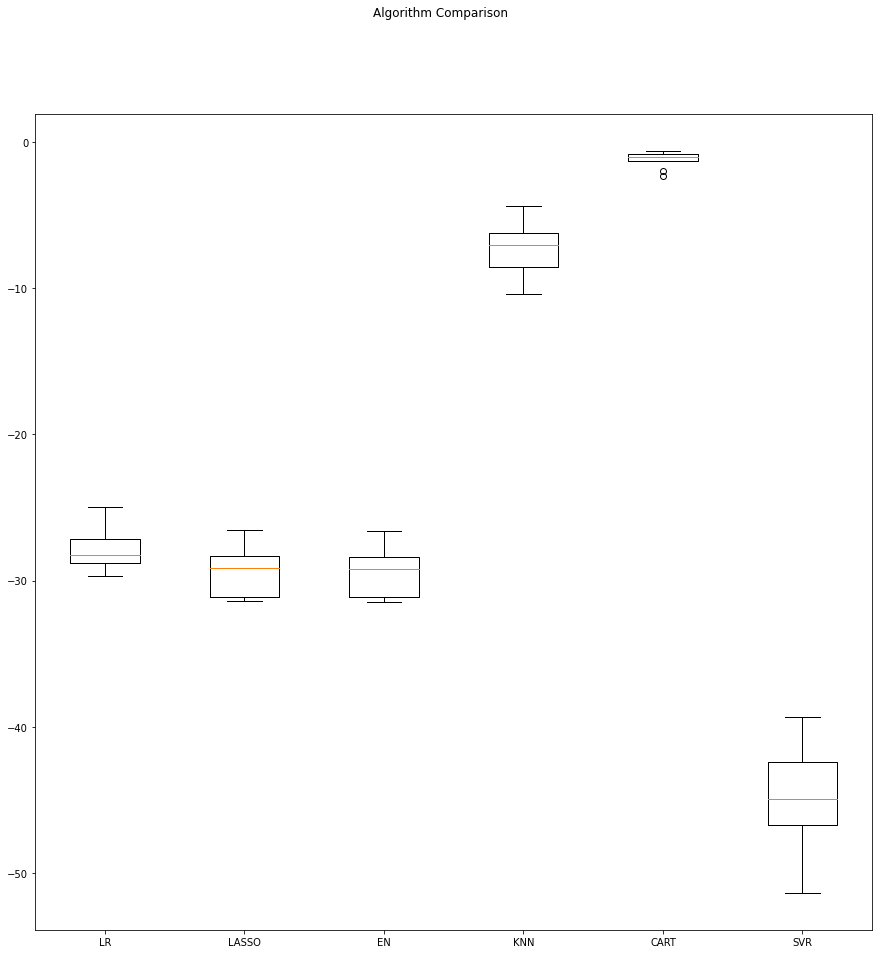

In [129]:
# Compare Algorithms
fig = plt.figure() 
fig.suptitle('Algorithm Comparison') 
ax = fig.add_subplot(111) 
plt.boxplot(results) 
ax.set_xticklabels(names);

In [132]:
# Standardize the dataset
pipelines = []
pipelines.append(('ScaledLR', Pipeline([('Scaler', StandardScaler()),('LR', LinearRegression())])))
pipelines.append(('ScaledLASSO', Pipeline([('Scaler', StandardScaler()),('LASSO', Lasso())])))
pipelines.append(('ScaledEN', Pipeline([('Scaler', StandardScaler()),('EN', ElasticNet())])))
pipelines.append(('ScaledKNN', Pipeline([('Scaler', StandardScaler()),('KNN', KNeighborsRegressor())])))
pipelines.append(('ScaledCART', Pipeline([('Scaler', StandardScaler()),('CART', DecisionTreeRegressor())])))
pipelines.append(('ScaledSVR', Pipeline([('Scaler', StandardScaler()),('SVR', SVR())]))) 
results = []
names = []
for name, model in pipelines:
  kfold = KFold(n_splits=num_folds, random_state=seed, shuffle=True)
  cv_results = cross_val_score(model, X_train, y_train, cv=kfold, scoring=scoring)
  results.append(cv_results)
  names.append(name)
  msg = "%s: %f (%f)" % (name, cv_results.mean(), cv_results.std())
  print(msg)

ScaledLR: -27.941384 (1.342601)
ScaledLASSO: -31.538014 (1.699536)
ScaledEN: -43.919407 (1.650595)
ScaledKNN: -4.842584 (0.768371)
ScaledCART: -1.223359 (0.553345)
ScaledSVR: -5.435082 (1.069214)


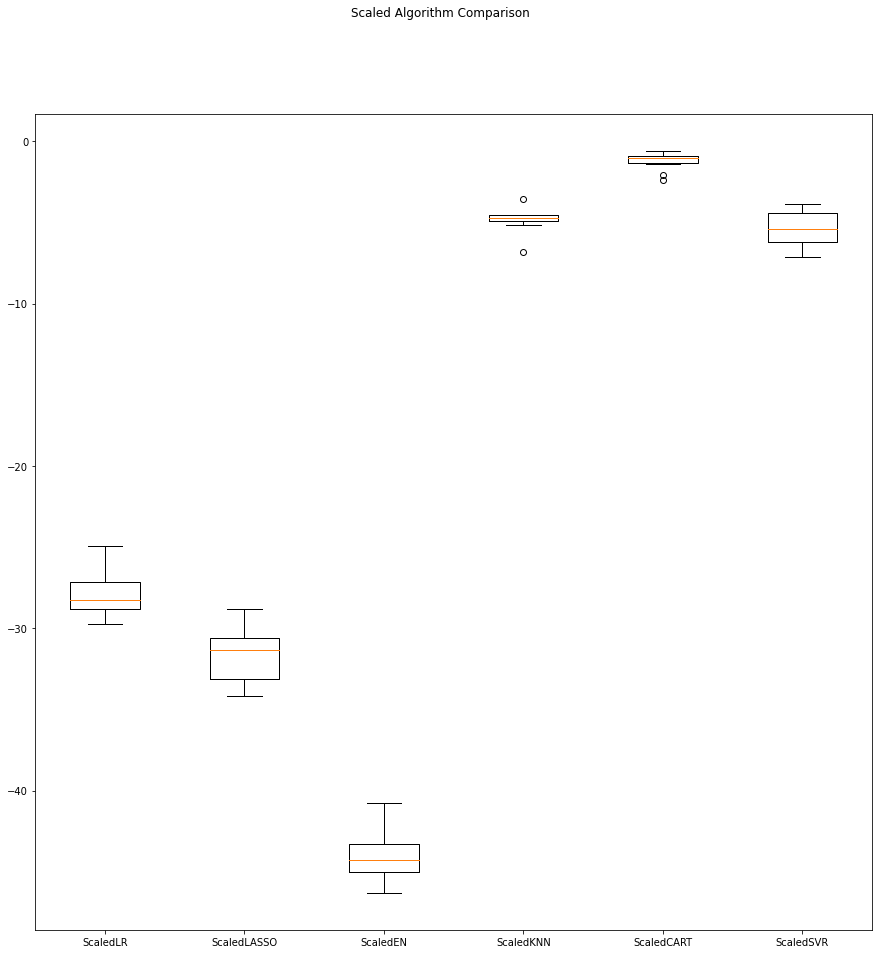

In [133]:
# Compare Algorithms
fig = plt.figure()
fig.suptitle('Scaled Algorithm Comparison') 
ax = fig.add_subplot(111) 
plt.boxplot(results) 
ax.set_xticklabels(names);

In [ ]:
# KNN Algorithm tuning
scaler = StandardScaler().fit(X_train)
rescaledX = scaler.transform(X_train)
k_values = numpy.array([1,3,5,7,9,11,13,15,17,19,21])
param_grid = dict(n_neighbors=k_values)
model = KNeighborsRegressor()
kfold = KFold(n_splits=num_folds, random_state=seed, shuffle=True)
grid = GridSearchCV(estimator=model, param_grid=param_grid, scoring=scoring, cv=kfold)
grid_result = grid.fit(rescaledX, Y_train)

In [ ]:
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_)) means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))